#### **Machine Translation with a Sequence-to-Sequence Model**

We explore the Machine Translation (MT) task using RNN-based sequence-to-sequence (seq2seq) models.

We will use a Vietnamese-English dataset from IWSLT'15. The task is to translate a Vietnamese sentence into English.

The [framework](https://github.com/lingo-mit/6864-hw2/blob/master/6864_hw2b.ipynb) for the code was provided by the TAs for MIT 6.864 (Advanced Natural Language Processing), Spring 2020.



#### **Setup**

Import required libraries and read in the dataset.

If the dataset is not downloaded, we download it and place it under the "data" directory.

In [8]:
import os
import numpy as np
import math
import time

import matplotlib.pyplot as plt

import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

!pip install sacrebleu
import sacrebleu

import util
from util import MTDataset


device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu!


# util.get_dataset("en_vi_iwslt_15")

#### **Data Preprocessing**

We do some simple data preprocessing and show some data statistics.



Number of training (src, trg) sentence pairs: %d 23322
Number of validation (src, trg) sentence pairs: %d 2591
Number of testing (src, trg) sentence pairs: %d 233
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d 7710
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d 17192
Training sentence avg. length: %d  32.04364977274676
Training sentence length at 95-percentile: %d 46.0


Training sentence length distribution (x-axis is length range and y-axis is count)



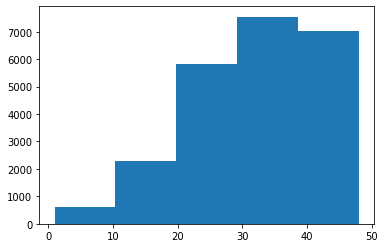

Example Vietnamese input: Riêng tôi , tôi mê ý tưởng này cực kì .
Its target English output: For me , I really love this idea .


In [9]:
# Note in the vocab files for English and Vietnamese, each line is a word in the vocabulary,
# that's why we set "type" to sentence
src_vocab_set = util.read_file_txt(os.path.join("../data", "vocab.vi"), encoding = None, type = "sentence")
trg_vocab_set = util.read_file_txt(os.path.join("../data", "vocab.en"), encoding = None, type = "sentence")

train_src_sentences_list = util.read_file_txt(os.path.join("../data", "train.vi"))
train_trg_sentences_list = util.read_file_txt(os.path.join("../data", "train.en"))
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = util.read_file_txt(os.path.join("../data", "tst2013.vi"))
test_trg_sentences_list = util.read_file_txt(os.path.join("../data", "tst2013.en"))
assert len(test_src_sentences_list) == len(test_trg_sentences_list)


train_src_sentences_list, train_trg_sentences_list = util.filter_data(train_src_sentences_list, train_trg_sentences_list)
test_src_sentences_list, test_trg_sentences_list = util.filter_data(test_src_sentences_list, test_trg_sentences_list)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

# Show some data stats
print("Number of training (src, trg) sentence pairs: %d", len(train_src_sentences_list))
print("Number of validation (src, trg) sentence pairs: %d", len(val_src_sentences_list))
print("Number of testing (src, trg) sentence pairs: %d", len(test_src_sentences_list))

src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d", len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d", len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ', np.mean(length))
print('Training sentence length at 95-percentile: %d', np.percentile(length, 95))
print("\n")

print('Training sentence length distribution (x-axis is length range and y-axis is count)\n')
plt.hist(length, bins=5)
plt.show()

print('Example Vietnamese input: ' + str(train_src_sentences_list[1]))
print('Its target English output: ' + str(train_trg_sentences_list[1]))

#### **Encoder**

RNN seq2seq models consists of an encoder RNN and a decoder RNN.
In a vanilla seq2seq model where there is no attention mechanism between encoder and decoder, the encoder aims to compress the information contained in the entire input sequence into a single vector and pass it to decoder.

We start with implementing the encoder, which is just a simple RNN. Here we use the [GRU](https://pytorch.org/docs/stable/nn.html#gru) architecture for the RNN.

In [0]:
class Encoder(nn.Module):

  def __init__(self, input_size, hidden_size, dropout = 0.00):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training.
         Note that for 1-layer RNN this has no effect since dropout only applies to outputs of intermediate layers.
    """
    
    super().__init__()
    self.rnn = nn.GRU(input_size, hidden_size, num_layers = 1, batch_first = True, dropout = dropout, bidirectional = False)

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).
    """
    # print("inputs.shape:", inputs.shape)
    # print("lengths.shape:", lengths.shape)

    packed_input = pack_padded_sequence(inputs, lengths, batch_first = True, enforce_sorted = False)
    outputs, finals = self.rnn(packed_input)
    outputs, outputs_len = pad_packed_sequence(outputs, batch_first = True)

    return outputs, finals

#### **Decoder**

A RNN decoder that uses the encoder's last hidden state to initialize its initial hidden state.

In [0]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout = 0.00):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super().__init__()
    self.rnn = nn.GRU(input_size, hidden_size, num_layers = 1, batch_first = True, dropout = dropout, bidirectional = False)

    
  def forward(self, inputs, encoder_finals, hidden=None, max_len = None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
          We will convert it later in a `Generator` below.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    outputs, hidden = self.rnn(inputs, hidden)

    # return hidden, outputs
    return outputs, hidden

  def init_hidden(self, encoder_finals):
    """ Use encoder final hidden state to initialize decoder's first hidden state."""
    decoder_init_hiddens = encoder_finals

    return decoder_init_hiddens

#### **Encoder-Decoder**

We define the high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings.

In [0]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    _, encoder_finals = self.encode(src_ids, src_lengths)
    # trg_ids_new = trg_ids[:, :-1]
    # print("trg_ids:", trg_ids.shape, "trg_ids_new", trg_ids_new.shape)
    decoder_outputs, decoder_hiddens = self.decode(encoder_finals, trg_ids[:, :-1])

    return decoder_outputs, decoder_hiddens

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden = None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

#### **Generator**

It simply projects the pre-output layer (x in the forward function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [0]:
class Generator(nn.Module):
  
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super().__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias = False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

#### **Training and Testing**


##### **Dataloading**

Apply the dataloader to the dataset. The dataloader provides a convenient way to iterate through the whole dataset.

In [0]:
batch_size = 128

# note - the size of the training set may be reduced by setting a smaller value for "sampling"
train_set = util.MTDataset(train_src_sentences_list, src_vocab_set, train_trg_sentences_list, trg_vocab_set, sampling=1.)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size, num_workers=8, shuffle=True)

val_set = util.MTDataset(val_src_sentences_list, src_vocab_set, val_trg_sentences_list, trg_vocab_set, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8, shuffle=False)

##### **Training**

The main functions for training, here we use perplexity to evaluate the performance of the model.

In [15]:
def run_epoch(data_loader, model, loss_compute, print_every, start_time):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for idx, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)
    del trg_lengths_B   # unused

    # print("src_ids_BxT:", src_ids_BxT.shape)
    # print("trg_ids_BxL:", trg_ids_BxL.shape)
    # print("src_lengths_B:", src_lengths_B.shape)

    # _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)
    output, _ = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)
    # print("output.shape:", output.shape)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:], norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()


    if model.training and idx % print_every == 0:
      print("iteration: {}, time: {}, loss: {:0.4f}".format(idx, util.time_since(start_time), loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


PAD_INDEX = 0

def train(model, num_epochs, learning_rate, print_every):
  criterion = nn.NLLLoss(reduction = "sum", ignore_index = PAD_INDEX)   # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when computing the loss.
  optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

  dev_ppls = []   # keep track of dev perplexity for each epoch
  start = time.time()

  for idx in range(num_epochs):
    print("epoch", idx)

    model.train()
    train_ppl = run_epoch(data_loader = train_data_loader, model = model,
                          loss_compute = util.SimpleLossCompute(model, criterion, optim),
                          print_every = print_every, start_time = start)
         
    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader = val_data_loader, model = model,
                          loss_compute = util.SimpleLossCompute(model, criterion, None),
                          print_every = print_every, start_time = start)
      
      print("validation perplexity: {:0.4f}".format(dev_ppl))
      dev_ppls.append(dev_ppl)
        
  return dev_ppls


# Hyperparameters for contructing the encoder-decoder model
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.00

pure_seq2seq = EncoderDecoder(
  encoder = Encoder(embed_size, hidden_size, dropout = dropout),
  decoder = Decoder(embed_size, hidden_size, dropout = dropout),
  src_embed = nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed = nn.Embedding(len(trg_vocab_set), embed_size),
  generator = Generator(hidden_size, len(trg_vocab_set))).to(device)


pure_dev_ppls = train(pure_seq2seq, num_epochs = 2, learning_rate = 1e-3, print_every = 100) 

epoch 0
iteration: 0, time: 0m 2s, loss: 317.1935
iteration: 100, time: 0m 41s, loss: 54.8127
validation perplexity: 4.5010
epoch 1
iteration: 0, time: 1m 21s, loss: 51.1021
iteration: 100, time: 1m 58s, loss: 49.0548
validation perplexity: 4.0048


#### **Evaluation**


##### **Perplexity**

Plot the perplexity graph

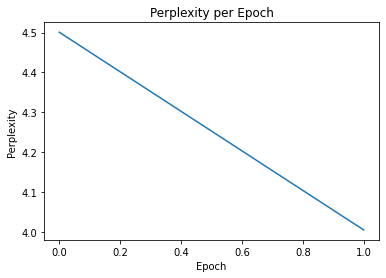

In [16]:
util.plot_perplexity(pure_dev_ppls)

##### **Decoding**

Decode the model output. For simplicity, we use greedy search here.

In [0]:
def greedy_decode(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderDecoder."""

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output
  

def lookup_words(x, vocab):
  return [vocab[i] for i in x]

Print the top 3 examples from the data loader by applying the greedy decoder. Here we use the validation dataset to print examples.

In [18]:
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50
SOS_INDEX = 2
EOS_INDEX = 3
NUM_EXAMPLES = 3
SRC_VOCAB_SET = src_vocab_set
TRG_VOCAB_SET = trg_vocab_set

def print_examples(model, data_loader):
  """Prints NUM_EXAMPLES. Assumes a batch size of 1."""

  model.eval()

  for idx, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
    result = greedy_decode(model, src_ids.to(device), src_lengths.to(device), max_len = MAX_SENT_LENGTH_PLUS_SOS_EOS)

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    print("example ", idx + 1)
    print("src: ", " ".join(lookup_words(src_ids, vocab = SRC_VOCAB_SET)))
    print("trg: ", " ".join(lookup_words(trg_ids, vocab = TRG_VOCAB_SET)))
    print("pred: ", " ".join(lookup_words(result, vocab = TRG_VOCAB_SET)))
    print()

    if idx == NUM_EXAMPLES - 1:
      break


example_set = util.MTDataset(val_src_sentences_list, src_vocab_set, val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(example_set, batch_size = 1, num_workers = 1, shuffle = False)

print_examples(pure_seq2seq, example_data_loader)

example  1
src:  C h <unk> n <unk> <unk> t ô i <unk> c h o <unk> n ó <unk> n ổ <unk> v à <unk> x e m <unk> x <unk> t <unk> t ừ n <unk> <unk> m ả n h <unk> n h <unk> <unk> .
trg:  W <unk> <unk> b l o <unk> <unk> i <unk> <unk> <unk> <unk> <unk> a n d <unk> l o o <unk> <unk> a <unk> <unk> <unk> <unk> <unk> <unk> <unk> i <unk> <unk> <unk> s <unk> .
pred:  W <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

example  2
src:  D <unk> <unk> v <unk> y <unk> , <unk> c h <unk> n <unk> <unk> t ô i <unk> v <unk> n <unk> x e m <unk> x <unk> t <unk> t ừ n <unk> <unk> m ả n h <unk> n h <unk> <unk> .
trg:  B <unk> <unk> <unk> s <unk> i l l <unk> , <unk> <unk> <unk> <unk> l o o <unk> <unk> a <unk> <unk> <unk> <unk> <unk> <unk> <unk> i <unk> <unk> <unk> s <unk> .


##### **BLEU score**

Compute the [BLEU](https://en.wikipedia.org/wiki/BLEU) score, a standard measure to evaluate the translation results.

In [19]:
# import sacrebleu
from tqdm import tqdm


def compute_bleu(model, data_loader):
  bleu_score = []

  model.eval()
  for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
    result = greedy_decode(model, src_ids.to(device), src_lengths.to(device), max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    pred = " ".join(lookup_words(result, vocab = TRG_VOCAB_SET))
    targ = " ".join(lookup_words(trg_ids, vocab = TRG_VOCAB_SET))

    bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)

  return bleu_score


test_set = MTDataset(test_src_sentences_list, SRC_VOCAB_SET, test_trg_sentences_list, TRG_VOCAB_SET, sampling = 1.)
test_data_loader = data.DataLoader(test_set, batch_size = 1, num_workers = 8, shuffle = False)

print("\nBLEU score: {:0.4f}".format(np.mean(compute_bleu(pure_seq2seq, test_data_loader))))

100%|██████████| 233/233 [00:11<00:00, 20.24it/s]


BLEU score: 15.1403
